# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Initialization</h1></span>
This note book is forked from [here](https://www.kaggle.com/code/motono0223/isic-pytorch-inference-baseline-image-only)

Credit:
* https://www.kaggle.com/code/samu2505/isic-pytorchmodel-training
    * This notebook added images from past ISIC datasets and I used it to enlarge the size of positive cases
    
Future Improvements:
* I used EffNet_b3, and maybe other model could have better performance.
* The size of dataset is limited due to the computation power. if you have better machine, you could enlarge the dataset of training.
* Parameter finetuning (the epoch = 30 now).
* I only one fold out of five, which can be changed.

Notebooks:
- [Training notebook](https://www.kaggle.com/code/hugowjd/isic-2024-pytorch-training-effnet-b3)
- Inference notebook (This notebook)

Updates:
* Version 1-11: Testing from Eff_b0 to Eff_b3
* Version 12-13: Enable multi-fold inference and test with Eff_b2(5 folds and 10 epoches for each)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries</h1></span>

In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

# Plot package
import PIL
from matplotlib import pyplot as plt

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration</h1></span>

In [2]:
CONFIG = {
    "seed": 42,
    "img_size": 384,
    # "model_name": "densenet121.tv_in1k",
    "model_name": "tf_efficientnet_b2_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b3/1/tf_efficientnet_b3_aa-84b4657e.pth",
    "valid_batch_size": 32,
    "multiple_fold": True,
    "n_fold": 5,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])
def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

In [4]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

#BEST_WEIGHT = "/kaggle/input/k/hugowjd/isic-pytorch-training-baseline-image-only/best_AUROC_model.bin"
BEST_WEIGHT = "/kaggle/input/k/hugowjd/isic-pytorch-training-baseline-image-only/best_VAL_LOSS_model_0.bin"
WEIGHT_DIR = "/kaggle/input/k/hugowjd/isic-pytorch-training-baseline-image-only/"
WEIGHT_TYPE = "best_AUROC_model" # best_VAL_LOSS_model/best_AUROC_model/Final_model

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [5]:
df = pd.read_csv(TEST_CSV)
df['target'] = 0 # dummy
df

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,target
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY,0
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY,0
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY,0


In [6]:
df_sub = pd.read_csv(SAMPLE)
df_sub

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


Display top 3 test images


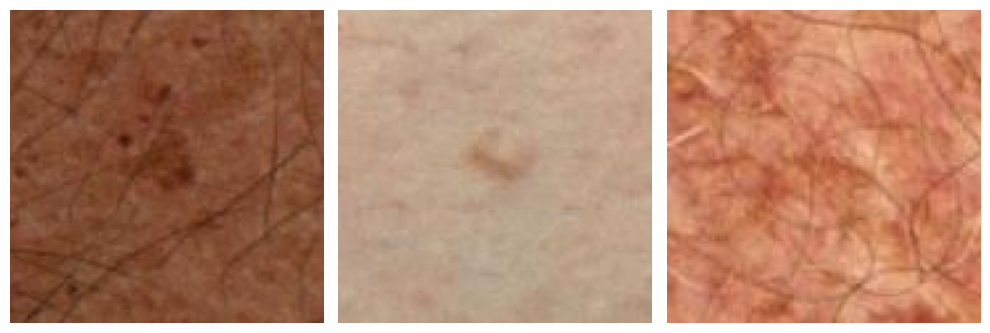

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10,10))
axes = axes.flatten()
test_image = h5py.File(TEST_HDF, mode="r")
print("Display top 3 test images")
for i, isic_id in enumerate(df.iloc[:3]["isic_id"]):
    img = Image.open(BytesIO(test_image[isic_id][()])).convert("RGB")
    axes[i].imshow(img)
    axes[i].axis(False)
plt.tight_layout()
plt.show()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [8]:
class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target,
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [9]:
data_transforms = {
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [10]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [11]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output
    
# model = ISICModel(CONFIG['model_name'], pretrained=False)
# model.load_state_dict(torch.load(BEST_WEIGHT) )
# model.to(CONFIG['device']);

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [12]:
test_dataset = ISICDataset(df, TEST_HDF, transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Inference</span>

In [13]:
if CONFIG["multiple_fold"]:
    for fold in range(CONFIG['n_fold']):
        print(f'Fold - {fold}')
        torch.cuda.empty_cache()
        model = ISICModel(CONFIG['model_name'], pretrained=False)
        BEST_WEIGHT_PATH = f'{WEIGHT_DIR}{WEIGHT_TYPE}_{fold}.bin'
        model.load_state_dict(torch.load(BEST_WEIGHT_PATH) )
        model.to(CONFIG['device'])
        preds = []
        with torch.no_grad():
            bar = tqdm(enumerate(test_loader), total=len(test_loader))
            for step, data in bar:        
                images = data['image'].to(CONFIG["device"], dtype=torch.float)        
                batch_size = images.size(0)
                outputs = model(images)
                preds.append( outputs.detach().cpu().numpy() )
        preds = np.concatenate(preds).flatten()
        col = f'target{fold}'
        df_sub[col] = preds
    cols = [f'target{fold}' for fold in range(CONFIG['n_fold'])]
    df_sub['target'] = df_sub[cols].mean(axis=1)
else:
    model = ISICModel(CONFIG['model_name'], pretrained=False)
    model.load_state_dict(torch.load(BEST_WEIGHT) )
    model.to(CONFIG['device']);
    preds = []
    with torch.no_grad():
        bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images)
            preds.append( outputs.detach().cpu().numpy() )
    preds = np.concatenate(preds).flatten()
    df_sub["target"] = preds

Fold - 0


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fold - 1


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Fold - 2


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


Fold - 3


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Fold - 4


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


In [14]:
df_sub

,isic_id,target,target0,target1,target2,target3,target4
0,ISIC_0015657,0.923158,0.984176,0.982040,0.989001,0.999060,0.661513
1,ISIC_0015729,0.003921,0.008995,0.002910,0.001244,0.002379,0.004077
2,ISIC_0015740,0.009614,0.011276,0.005009,0.006046,0.004211,0.021525


In [15]:
df_sub[['isic_id', 'target']].to_csv("submission.csv", index=False)